# Bayesian amplitude regression

In the lectures you should've now covered, or at least discussed Bayesian networks.  Here we'll show you how to build these networks and use them in practice.

We will start by constructing a Bayesian layer in pytorch, and then building the Bayesian loss function.  We will then construct a Bayesian network from these layers, and use it to perform the same amplitude regression from the previous tutorial.  We will discuss how to analyse the outputs of the Bayesian network, and how this gives us the ability to estimate the error on our analysis.  This last step is crucial to the application of any numerical technique in physics.

#### Outline / tasks:
 - Imports \& plotting set-up
 - Loading the data
 - Visualising the data
     - visualise some of the kinematics of the process (transverse momentum of photons/gluons, MET)
     - histogram the amplitudes
 - Preprocessing the data
     - neural networks like $\mathcal{O}(1)$ numbers
     - how should we preprocess the data?
 - Datasets and dataloaders
     - details are in the pytorch docs
 - Building a Bayesian layer
 - Constructing the Bayesian loss function
 - Building the Bayesian neural network
 - Optimising the neural network
 - Plot the train and validation losses as a function of the epochs
 - Study the results

     
Most practical pytorch skills you need for this work is covered in the basics tutorial at https://pytorch.org/tutorials/beginner/basics/intro.html.

Please download the training data `tutorial-2-data.zip` and extract it to the folder `data/tutorial-2-data/`.

If you want to run this tutorial in google colab, you can open a new colab and then upload this file. 

The data can be downloaded using

```
NEEDS TO BE CHANGED!
!wget -O tutorial-2-data.zip https://www.dropbox.com/s/n5e66w91rgmbqz2/dlpp-data.zip?dl=0&file_subpath=%2Fdlpp-data%2Ftutorial-2-data
!unzip "tutorial-2-data.zip"
!mkdir tutorial-2-data
!mv dlpp-data/tutorial-2-data/* tutorial-2-data/.
!rm -r __MACOSX/
!rm -r dlpp-data/
!ls
```

Make sure you switch to a GPU runtime to fully utilize the colab. 

### Imports

In [1]:
import os
import sys
import random
import time
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
from torch.nn import functional as F
from torch.nn import init
from torch.nn import Module

#### Plotting set-up

In [2]:
from matplotlib import pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings("ignore")
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties
import matplotlib.colors as mcolors
import colorsys


## Loading the data

In [3]:
trn_dat = np.load("data/tutorial-2-data/trn_dat.npy")
trn_amp = np.load("data/tutorial-2-data/trn_amp.npy")

val_dat = np.load("data/tutorial-2-data/val_dat.npy")
val_amp = np.load("data/tutorial-2-data/val_amp.npy")

tst_dat = np.load("data/tutorial-2-data/tst_dat.npy")
tst_amp = np.load("data/tutorial-2-data/tst_amp.npy")

In [4]:
print(f"train data shape: {trn_dat.shape}")
print(f"train amp  shape: {trn_amp.shape}")
print(f"test  data shape: {tst_dat.shape}")
print(f"test  amp  shape: {tst_amp.shape}")
print(f"val   data shape: {val_dat.shape}")
print(f"val   amp  shape: {val_amp.shape}")

train data shape: (30000, 5, 4)
train amp  shape: (30000,)
test  data shape: (30000, 5, 4)
test  amp  shape: (30000,)
val   data shape: (30000, 5, 4)
val   amp  shape: (30000,)


We will not repeat the visualisation of the data, see the previous tutorial for this.

## Preprocessing the data

In [5]:
def get_pt(fv):
    """ returns p_T of given four vector """
    ptsq = np.round(fv[:, 1]**2 + fv[:, 2]**2, 5)
    return np.sqrt(ptsq)

In [6]:
# index 2 is leading photon, not gluon (which is 4)
trn_dat_gluon_pt = get_pt(trn_dat[:, 4])



In [7]:
nev = trn_dat.shape[0]
trn_datf = np.reshape(trn_dat, (nev,-1))
val_datf = np.reshape(val_dat, (nev,-1))
tst_datf = np.reshape(tst_dat, (nev,-1))

In [8]:
trn_datf.shape

(30000, 20)

In [9]:
gpt = np.mean(trn_dat_gluon_pt)
trn_datf = trn_datf / gpt
val_datf = val_datf / gpt
tst_datf = tst_datf / gpt

In [10]:
trn_datfp = torch.Tensor(trn_datf)
val_datfp = torch.Tensor(val_datf)
tst_datfp = torch.Tensor(tst_datf)

In [11]:
trn_ampl = np.log(trn_amp)
val_ampl = np.log(val_amp)
tst_ampl = np.log(tst_amp)

In [12]:
trn_amplp = torch.Tensor(trn_ampl)
val_amplp = torch.Tensor(val_ampl)
tst_amplp = torch.Tensor(tst_ampl)

## Datasets and dataloaders

In [13]:
class amp_dataset(Dataset):
    
    def __init__(self, data, amp):
        self.data = data
        self.amp = amp

    def __len__(self):
        return len(self.amp)

    def __getitem__(self, idx):
        return self.data[idx], self.amp[idx]

In [14]:
trn_dataset = amp_dataset(trn_datfp, trn_amplp.unsqueeze(-1))
val_dataset = amp_dataset(val_datfp, val_amplp.unsqueeze(-1))
tst_dataset = amp_dataset(tst_datfp, tst_amplp.unsqueeze(-1))

In [15]:
trn_dataloader = DataLoader(trn_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
tst_dataloader = DataLoader(tst_dataset, batch_size=64, shuffle=True)

## Building a Bayesian layer

First let's look at the source code for a **basic linear layer** in pytorch:

(https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear)

```
class Linear(Module):
    
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: Tensor

    def __init__(self, in_features: int, out_features: int, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.empty((out_features, in_features), **factory_kwargs))
        if bias:
            self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input: Tensor) -> Tensor:
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self) -> str:
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )
```

Objects of this class apply a linear transformation to the incoming data: $y = xA^T + b$.

The input arguments are required to initialise the layer, so, in the \_\_init()\_\_ function.  We have:
- in_features: size of each input sample
- out_features: size of each output sample
- bias: If set to ``False``, the layer will not learn an additive bias.  Default: ``True``

The shapes are:
- Input: $(*, H_{in})$ where $*$ means any number of dimensions including none and $H_{in} = \text{in_features}$.
- Output: $(*, H_{out})$ where all but the last dimension are the same shape as the input and $H_{out} = \text{out_features}$.

The layer has attributes:
- weight: the learnable weights of the module of shape $(\text{out_features}, \text{in_features})$. The values are initialized from $\mathcal{U}(-\sqrt{k}, \sqrt{k})$, where $k = \frac{1}{\text{in_features}}$
- bias:   the learnable bias of the module of shape $(\text{out_features})$.  If `bias` is ``True``, the values are initialized from $\mathcal{U}(-\sqrt{k}, \sqrt{k})$ where $k = \frac{1}{\text{in_features}}$.

Examples::

    >>> m = nn.Linear(20, 30)
    
    >>> input = torch.randn(128, 20)
    
    >>> output = m(input)
    
    >>> print(output.size())
    
    torch.Size([128, 30])

From the lecture, we know that in a Bayesian network the weights are replaced by Gaussian distributions, and on a forward pass we get the output by sampling from that distribution.

So the biases are the same as in the linear layer.  But not each weight is a Gaussian distibution and so needs a mean and a variance.  The bias and the mean and variance of the weight distribution will be learnable.  In practice it's easier to work with the log of the variance as it is more stable when optimising the network.

We need to be able to sample from the Gaussian weight distributions, and compute derivatives of the output in order to update the network parameters.  To do this we use something called the 're-parameterisation trick'.  It involves sampling random noise from a unit normal distribution, and then transforming that number using the mean and variance of the weight distribution in this way:
\begin{equation}
w = \mu + \sigma\times r
\end{equation}
where $r$ is a random number sampled from a unit normal distribution (Gaussian with mean and variance equal to one), $\mu$ is the mean of the weight distribution, and $\sigma$ is the standard deviation.  In this way we separate the stochastic part of the function from the parameters defining the distribution.  And so if we take any differentiable function of $x$ (e.g. an activation function), we can compute derivatives of that function with respect to the mean and variance of the weight distribution.

In the `forward` method we then need to implement this reparameterisation trick for the weights, and then apply the same linear transformation as in the standard linear layer.

On each forward pass we need to generate a set of random numbers with the same shape as our means and variances.  Choosing a set of random numbers for the sampling is equivalent to 'sampling' a new neural network from the Bayesian neural network.  And sometimes at the end of the analysis, we will want to keep the same network for testing.  So we don't always want to re-sample the random numbers on each forward pass.  To control this we define a flag called `self.resample`, with default set to ``True``.

We also need a `reset_parameters` function to reset the parameters in the network.  This is standard for layers in pytorch.  We use a slightly different function to do this than is used in the pytorch linear layer, as can be seen below.

From the lecture, you know that the weight distributions require a prior.  The simplest choice for this prior is just a Gaussian distribution with a mean and variance of one.  Results are typically not too sensitive to this prior, as long as the values are within reasonable limits.  For example, $\mathcal{O}(1)$ means and standard deviations.  Going beyond $\mathcal{O}(1)$ numbers just leads to numerical instabilities in the training.  The Bayesian loss function contains a term coming from the KL divergence between the weight distributions in the network and their priors.  So the layers should have some funcitonality to return these values.  The KL divergence for the layer is:
\begin{equation}
\text{KL} = \sum_{\text{weights}} 0.5 \times (  \mu^2 + \sigma^2 - \log\sigma^2 - 1 )
\end{equation}

So let's build the **simplest Bayesian layer** we can.

In [16]:
class VBLinear(Module):
    # VB -> Variational Bayes
    
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: Tensor
    
    def __init__(self, in_features, out_features):
        super(VBLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.resample = True
        self.bias = Parameter(Tensor(out_features))
        self.mu_w = Parameter(Tensor(out_features, in_features))
        self.logsig2_w = Parameter(Tensor(out_features, in_features))
        self.random = torch.randn_like(self.logsig2_w)
        self.reset_parameters()
        
    def forward(self, inpt):
        if self.resample:
            self.random = torch.randn_like(self.logsig2_w)
        s2_w = self.logsig2_w.exp()
        weight = self.mu_w + s2_w.sqrt() * self.random
        return nn.functional.linear(inpt, weight, self.bias) #+ 1e-8
    
    def reset_parameters(self):
        stdv = 1. / np.sqrt(self.mu_w.size(1))
        self.mu_w.data.normal_(0, stdv)
        self.logsig2_w.data.zero_().normal_(-9, 0.001)
        self.bias.data.zero_()
        
    def KL(self, loguniform=False):
        kl = 0.5 * (self.mu_w.pow(2) + self.logsig2_w.exp() - self.logsig2_w - 1).sum()
        return kl

Let's test the layers, define:

In [17]:
tlr0 = VBLinear(10, 5)
tlr1 = VBLinear(5, 2)

Now some test data, a batch of 20 vectors with 10 elements each:

In [18]:
x = torch.rand(20, 10)

Now pass the data first through layer0 then through layer1:

In [19]:
tlr1(tlr0(x))

tensor([[-2.7731e-01,  8.3171e-01],
        [-3.1769e-02,  5.3920e-01],
        [ 2.2206e-01,  4.9462e-01],
        [ 2.7117e-01,  6.9837e-03],
        [ 3.4637e-01,  3.6407e-01],
        [ 5.1559e-01,  7.8347e-01],
        [ 7.0615e-01,  1.1547e-01],
        [ 4.9982e-01,  2.6103e-01],
        [-5.5030e-02,  8.1928e-01],
        [ 5.1803e-02,  7.7110e-01],
        [ 3.0633e-04,  5.1951e-01],
        [ 3.3047e-01,  7.2719e-01],
        [ 7.0073e-01,  9.4546e-02],
        [ 2.0342e-01,  9.4636e-01],
        [ 5.6899e-01,  7.6980e-02],
        [ 2.5679e-01,  2.9424e-01],
        [ 3.9362e-01,  8.4933e-01],
        [ 6.9639e-01,  2.9881e-01],
        [ 2.0888e-01,  7.4399e-01],
        [ 4.7607e-02,  1.1618e-01]], grad_fn=<AddmmBackward0>)

Note this has the correct shape:

In [20]:
tlr1(tlr0(x)).shape

torch.Size([20, 2])

Also try running the same data through the layer multiple times, you get different results.  This is because of the sampling in the Bayesian layer.

In [21]:
for i in range(5):
    print(tlr0(x)[0][0])

tensor(0.9953, grad_fn=<SelectBackward0>)
tensor(0.9405, grad_fn=<SelectBackward0>)
tensor(0.9374, grad_fn=<SelectBackward0>)
tensor(0.9313, grad_fn=<SelectBackward0>)
tensor(0.9450, grad_fn=<SelectBackward0>)


## The Bayesian loss function

From the lectures we know that there are two parts to the Bayesian loss function:
- The negative log Gaussian
- the KL from the network weights

The second comes from the layers, and the first is defined below.  This negative log Gaussian term acts on the two outputs from the Bayesian neural network:
- the mean
- the variance (which we parameterise as the log variance)

In [22]:
def neg_log_gauss(outputs, targets):

    mu = outputs[:, 0]
    logsigma2 = outputs[:, 1]
    out = torch.pow(mu - targets, 2) / (2 * logsigma2.exp()) + 1./2. * logsigma2
    
    return torch.mean(out)

## Building the Bayesian neural network

We'll build a simple network with one input and one output layer, and two hidden layers.  We define the dimensions of these layers below.

In [23]:
ipt_dim = 20
opt_dim = 1
hdn_dim = 50

Now we build a very simple class for our neural network, which we call amp_net.

In [24]:
class bayes_amp_net(Module):
    
    # default hdn_dim is 30, but can be changed upon initialisation
    def __init__(self, training_size, hdn_dim=50):

        super(bayes_amp_net, self).__init__()

        # the loss function depends on the amount of training data we have, so we need to store this
        self.training_size = training_size
        
        # the activation layers of the network are not bayesian
        # and we need to be able to access the bayesian layers separately

        self.vb_layers = []
        self.all_layers = []

        # define the input layer
        vb_layer = VBLinear(ipt_dim, hdn_dim)
        self.vb_layers.append(vb_layer)
        self.all_layers.append(vb_layer)
        self.all_layers.append(nn.ReLU())

        # loop over hidden layers
        for i in range(2):
            vb_layer = VBLinear(hdn_dim, hdn_dim)
            self.vb_layers.append(vb_layer)
            self.all_layers.append(vb_layer)
            self.all_layers.append(nn.ReLU())

        # define the output layer. use 2 dimensions to learn the uncertainty sigma_stoch=sigma_model,
        # see eq. 1.57 of 2211.01421
        vb_layer = VBLinear(hdn_dim, 2)
        self.vb_layers.append(vb_layer)
        self.all_layers.append(vb_layer)

        # define the model as a Sequential net over all layers
        self.model = nn.Sequential(*self.all_layers)

    # and of course the forward function
    def forward(self, x):
        out = self.model(x)
        return out

    # we need the KL from the bayesian layers to compute the loss function
    def KL(self):
        kl = 0
        for vb_layer in self.vb_layers:
            kl += vb_layer.KL()
        return kl / self.training_size
    
    # let's put the neg_log_gauss in the network class aswell since it is key to bayesian networks
    def neg_log_gauss(self, outputs, targets):
        mu = outputs[:, 0]
        logsigma2 = outputs[:, 1]
        out = torch.pow(mu - targets, 2) / (2 * logsigma2.exp()) + 1./2. * logsigma2
        return torch.mean(out)

Check if we have a GPU.

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


Initialise the neural network and send to the GPU if we have one.  We can also print the model to see what layers it has.

In [26]:
trn_len = trn_amplp.shape[0]
hdn_dim = 50
model = bayes_amp_net(trn_len, hdn_dim=hdn_dim).to(device)
print(model)

bayes_amp_net(
  (model): Sequential(
    (0): VBLinear()
    (1): ReLU()
    (2): VBLinear()
    (3): ReLU()
    (4): VBLinear()
    (5): ReLU()
    (6): VBLinear()
  )
)


Now we can test it briefly by throwing some random numbers into it.

In [27]:
X = torch.rand(5, 20, device=device)

Passing the numbers through the Bayesian network gives us different outputs each time we run it:

In [28]:
model(X)

tensor([[-0.0228, -0.0855],
        [-0.0264,  0.0029],
        [-0.1179, -0.1174],
        [-0.1168, -0.0795],
        [ 0.0148, -0.0195]], device='cuda:0', grad_fn=<AddmmBackward0>)

Note again that the output has the correct shape:

In [29]:
model(X).shape

torch.Size([5, 2])

The predicitons of the full Bayesian network should vary with each forward pass because of the weight sampling

In [30]:
# print predictions for the same input data
for i in range(5):
    print(model(X)[0])

tensor([-0.0204, -0.0988], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([-0.0088, -0.0850], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([ 0.0019, -0.0879], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([ 0.0020, -0.0992], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([-0.0120, -0.0994], device='cuda:0', grad_fn=<SelectBackward0>)


## Optimising (training) the neural network

The Bayesian loss function has two terms which we have already definedl; the negative los Gaussian, and the KL divergence between the network and the network prior.  The latter comes from the KL divergence over the weights in the network.

Now we can write a training loop for a single epoch.

In [31]:
def train_epoch(dataloader, model, optimizer):

    size = len(dataloader.dataset)
    model.train()
    loss_tot, kl_tot, neg_log_tot = 0.0, 0.0, 0.0
    loss_during_opt, kl_during_opt, neg_log_during_opt = 0., 0., 0.
    
    for batch, (X, y) in enumerate(dataloader):
        
        # pass data through network
        pred = model(X)
        
        # compute loss
        nl = model.neg_log_gauss(pred, y.reshape(-1))
        kl = model.KL()
        loss = nl + kl

        loss_during_opt += loss.item()
        kl_during_opt += kl.item()
        neg_log_during_opt += nl.item()

        # reset gradients in optimizer
        optimizer.zero_grad()
        
        # compute gradients
        loss.backward()
        
        # update weights with optimizer
        optimizer.step()
        
        # print the training loss every 100 updates
        if batch % 100 == 0:
            current = batch * len( X )
            print(f"current batch loss: {loss:>8f} KL: {kl:>8f} Neg-log {nl:>8f}  [{current:>5d}/{size:>5d}]")
    loss_live = loss_during_opt/len(dataloader)
    kl_live = kl_during_opt / len(dataloader)
    nl_live = neg_log_during_opt / len(dataloader)
    
    print(f"avg train loss per batch in training: {loss_live:>8f}")        
    return loss_live, kl_live, nl_live

To monitor the performance of the network on the regression task we want to calculate the loss of both the training data and the validation data on the same network, so we have the following functions:

In [32]:
def val_pass(dataloader, model):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    nls = 0.0
    kls = 0.0
    vls = 0.0
    mse = 0.0

    # we don't need gradients here since we only use the forward pass
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            nl = model.neg_log_gauss(pred, y.reshape(-1))
            kl = model.KL()
            vl = nl.item() + kl.item()
            mse += torch.mean((pred[:, 0] - y.reshape(-1))**2)
            nls += nl
            kls += kl
            vls += vl

    nls /= num_batches
    kls /= num_batches
    vls /= num_batches
    mse /= num_batches
    print( f"avg val loss per batch: {vls:>8f} KL: {kls:>8f} Neg-log {nls:>8f} MSE {mse:>8}" )
    
    return nls.cpu().numpy(), kls.cpu().numpy(), vls, mse.cpu().numpy()

def trn_pass(dataloader, model):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    nls = 0.0
    kls = 0.0
    tls = 0.0
    mse = 0.0

    # we don't need gradients here since we only use the forward pass
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            nl = model.neg_log_gauss(pred, y.reshape(-1))
            kl = model.KL()
            tl = nl.item() + kl.item()
            mse += torch.mean((pred[:, 0] - y.reshape(-1))**2)
            nls += nl
            kls += kl
            tls += tl

    nls /= num_batches
    kls /= num_batches
    tls /= num_batches
    mse /= num_batches
    print( f"avg trn loss per batch: {tls:>8f} KL: {kls:>8f} Neg-log {nls:>8f} MSE {mse:>8}" )
    
    return nls.cpu().numpy(), kls.cpu().numpy(), tls, mse.cpu().numpy()

Now we can train the model!

In [33]:
# a useful function to present things clearer
def seperator():
    print( "-----------------------------------------------" )

# reset some parameters
batch_size = 128

trn_dataset = amp_dataset(trn_datfp.to(device), trn_amplp.unsqueeze(-1).to(device))
val_dataset = amp_dataset(val_datfp.to(device), val_amplp.unsqueeze(-1).to(device))
tst_dataset = amp_dataset(tst_datfp.to(device), tst_amplp.unsqueeze(-1).to(device))

trn_dataloader = DataLoader(trn_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
tst_dataloader = DataLoader(tst_dataset, batch_size=batch_size, shuffle=True)
epochs = 500

# re-initialise the model and the optimizer
hdn_dim = 50
trn_len = trn_amplp.shape[0]
print(f"Training dataset length: {trn_len}")
model = bayes_amp_net(trn_len, hdn_dim=hdn_dim).to(device)
learning_rate = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
seperator()
print("model architecture")
seperator()
print(model)
total_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {total_parameters:d} trainable parameters")


# track train and val losses
trn_nl_losses = []
trn_kl_losses = []
trn_losses = []
trn_mse_losses = []
val_nl_losses = []
val_kl_losses = []
val_losses = []
val_mse_losses = []
trn_nl_losses_live = []
trn_kl_losses_live = []
trn_losses_live = []

for t in range(epochs):
    seperator()
    print(f"Epoch {t+1}")
    seperator()
    loss_live, kl_live, nl_live = train_epoch(trn_dataloader, model, optimizer)
    trn_nl_losses_live.append(nl_live)
    trn_kl_losses_live.append(kl_live)
    trn_losses_live.append(loss_live)
    seperator()
    trn_nl_loss, trn_kl_loss, trn_loss, trn_mse_loss = trn_pass(trn_dataloader, model)
    trn_nl_losses.append(trn_nl_loss)
    trn_kl_losses.append(trn_kl_loss)
    trn_losses.append(trn_loss)
    trn_mse_losses.append(trn_mse_loss)
    seperator()
    val_nl_loss, val_kl_loss, val_loss, val_mse_loss = val_pass(val_dataloader, model)
    val_nl_losses.append(val_nl_loss)
    val_kl_losses.append(val_kl_loss)
    val_losses.append(val_loss)
    val_mse_losses.append(val_mse_loss)
    seperator()
    print( "|" )
    
print("Done!")

Training dataset length: 30000
-----------------------------------------------
model architecture
-----------------------------------------------
bayes_amp_net(
  (model): Sequential(
    (0): VBLinear()
    (1): ReLU()
    (2): VBLinear()
    (3): ReLU()
    (4): VBLinear()
    (5): ReLU()
    (6): VBLinear()
  )
)
Model has 12352 trainable parameters
-----------------------------------------------
Epoch 1
-----------------------------------------------
current batch loss: 131.257019 KL: 0.815803 Neg-log 130.441223  [    0/30000]
current batch loss: 5.723981 KL: 0.814350 Neg-log 4.909632  [12800/30000]
current batch loss: 4.793431 KL: 0.812986 Neg-log 3.980446  [25600/30000]
avg train loss per batch in training: 14.400713
-----------------------------------------------
avg trn loss per batch: 4.356837 KL: 0.812527 Neg-log 3.544311 MSE 79.37751007080078
-----------------------------------------------
avg val loss per batch: 4.355132 KL: 0.812527 Neg-log 3.542607 MSE 78.64068603515625
-

current batch loss: 1.056168 KL: 0.785687 Neg-log 0.270482  [25600/30000]
avg train loss per batch in training: 1.131860
-----------------------------------------------
avg trn loss per batch: 1.075168 KL: 0.785340 Neg-log 0.289827 MSE 1.0716502666473389
-----------------------------------------------
avg val loss per batch: 1.079632 KL: 0.785340 Neg-log 0.294291 MSE 1.1142600774765015
-----------------------------------------------
|
-----------------------------------------------
Epoch 13
-----------------------------------------------
current batch loss: 0.918219 KL: 0.785341 Neg-log 0.132878  [    0/30000]
current batch loss: 0.936009 KL: 0.784354 Neg-log 0.151655  [12800/30000]
current batch loss: 1.260835 KL: 0.783359 Neg-log 0.477477  [25600/30000]
avg train loss per batch in training: 1.158134
-----------------------------------------------
avg trn loss per batch: 1.162962 KL: 0.783016 Neg-log 0.379946 MSE 1.0420767068862915
-----------------------------------------------
avg v

current batch loss: 0.468721 KL: 0.758576 Neg-log -0.289855  [12800/30000]
current batch loss: 0.507516 KL: 0.757650 Neg-log -0.250134  [25600/30000]
avg train loss per batch in training: 0.795077
-----------------------------------------------
avg trn loss per batch: 0.777771 KL: 0.757324 Neg-log 0.020448 MSE 0.5684816241264343
-----------------------------------------------
avg val loss per batch: 0.799526 KL: 0.757324 Neg-log 0.042203 MSE 0.5905191898345947
-----------------------------------------------
|
-----------------------------------------------
Epoch 25
-----------------------------------------------
current batch loss: 0.634956 KL: 0.757323 Neg-log -0.122367  [    0/30000]
current batch loss: 0.658388 KL: 0.756382 Neg-log -0.097994  [12800/30000]
current batch loss: 0.561633 KL: 0.755438 Neg-log -0.193806  [25600/30000]
avg train loss per batch in training: 0.849031
-----------------------------------------------
avg trn loss per batch: 0.688726 KL: 0.755112 Neg-log -0.066

current batch loss: 0.424978 KL: 0.732969 Neg-log -0.307991  [12800/30000]
current batch loss: 0.329804 KL: 0.732100 Neg-log -0.402296  [25600/30000]
avg train loss per batch in training: 0.560289
-----------------------------------------------
avg trn loss per batch: 0.438673 KL: 0.731802 Neg-log -0.293129 MSE 0.3056888282299042
-----------------------------------------------
avg val loss per batch: 0.461772 KL: 0.731802 Neg-log -0.270030 MSE 0.31292036175727844
-----------------------------------------------
|
-----------------------------------------------
Epoch 37
-----------------------------------------------
current batch loss: 0.764642 KL: 0.731802 Neg-log 0.032839  [    0/30000]
current batch loss: 0.462128 KL: 0.730925 Neg-log -0.268797  [12800/30000]
current batch loss: 0.314425 KL: 0.730051 Neg-log -0.415626  [25600/30000]
avg train loss per batch in training: 0.537434
-----------------------------------------------
avg trn loss per batch: 0.467092 KL: 0.729742 Neg-log -0.2

current batch loss: 0.184444 KL: 0.710210 Neg-log -0.525766  [12800/30000]
current batch loss: 0.113640 KL: 0.709427 Neg-log -0.595787  [25600/30000]
avg train loss per batch in training: 0.317502
-----------------------------------------------
avg trn loss per batch: 0.235497 KL: 0.709154 Neg-log -0.473659 MSE 0.20335382223129272
-----------------------------------------------
avg val loss per batch: 0.265473 KL: 0.709154 Neg-log -0.443683 MSE 0.2183050811290741
-----------------------------------------------
|
-----------------------------------------------
Epoch 49
-----------------------------------------------
current batch loss: 1.179960 KL: 0.709156 Neg-log 0.470804  [    0/30000]
current batch loss: 0.492767 KL: 0.708381 Neg-log -0.215615  [12800/30000]
current batch loss: 0.136197 KL: 0.707611 Neg-log -0.571414  [25600/30000]
avg train loss per batch in training: 0.340100
-----------------------------------------------
avg trn loss per batch: 0.386427 KL: 0.707356 Neg-log -0.3

current batch loss: 0.080303 KL: 0.689848 Neg-log -0.609544  [12800/30000]
current batch loss: 0.165904 KL: 0.689153 Neg-log -0.523249  [25600/30000]
avg train loss per batch in training: 0.261409
-----------------------------------------------
avg trn loss per batch: 0.150375 KL: 0.688913 Neg-log -0.538538 MSE 0.1902751624584198
-----------------------------------------------
avg val loss per batch: 0.124913 KL: 0.688913 Neg-log -0.563999 MSE 0.1801215410232544
-----------------------------------------------
|
-----------------------------------------------
Epoch 61
-----------------------------------------------
current batch loss: 0.778314 KL: 0.688913 Neg-log 0.089402  [    0/30000]
current batch loss: -0.003189 KL: 0.688224 Neg-log -0.691413  [12800/30000]
current batch loss: -0.166669 KL: 0.687552 Neg-log -0.854221  [25600/30000]
avg train loss per batch in training: 0.207345
-----------------------------------------------
avg trn loss per batch: 0.098873 KL: 0.687323 Neg-log -0.

current batch loss: 0.382622 KL: 0.672717 Neg-log -0.290095  [12800/30000]
current batch loss: -0.170943 KL: 0.672127 Neg-log -0.843071  [25600/30000]
avg train loss per batch in training: 0.171180
-----------------------------------------------
avg trn loss per batch: 0.053793 KL: 0.671915 Neg-log -0.618121 MSE 0.1472889631986618
-----------------------------------------------
avg val loss per batch: 0.124012 KL: 0.671915 Neg-log -0.547902 MSE 0.16948972642421722
-----------------------------------------------
|
-----------------------------------------------
Epoch 73
-----------------------------------------------
current batch loss: 0.241400 KL: 0.671914 Neg-log -0.430514  [    0/30000]
current batch loss: 0.168800 KL: 0.671332 Neg-log -0.502532  [12800/30000]
current batch loss: -0.132042 KL: 0.670778 Neg-log -0.802820  [25600/30000]
avg train loss per batch in training: 0.059157
-----------------------------------------------
avg trn loss per batch: 0.336029 KL: 0.670572 Neg-log -

current batch loss: -0.388063 KL: 0.658641 Neg-log -1.046704  [12800/30000]
current batch loss: 0.551653 KL: 0.658202 Neg-log -0.106549  [25600/30000]
avg train loss per batch in training: 0.052424
-----------------------------------------------
avg trn loss per batch: 0.499898 KL: 0.658051 Neg-log -0.158154 MSE 0.3045263886451721
-----------------------------------------------
avg val loss per batch: 0.470036 KL: 0.658051 Neg-log -0.188016 MSE 0.28645190596580505
-----------------------------------------------
|
-----------------------------------------------
Epoch 85
-----------------------------------------------
current batch loss: 0.524472 KL: 0.658052 Neg-log -0.133580  [    0/30000]
current batch loss: -0.127619 KL: 0.657602 Neg-log -0.785221  [12800/30000]
current batch loss: -0.050494 KL: 0.657153 Neg-log -0.707647  [25600/30000]
avg train loss per batch in training: 0.035040
-----------------------------------------------
avg trn loss per batch: -0.105199 KL: 0.656992 Neg-log

current batch loss: -0.277197 KL: 0.646495 Neg-log -0.923692  [12800/30000]
current batch loss: -0.138528 KL: 0.646085 Neg-log -0.784613  [25600/30000]
avg train loss per batch in training: -0.093766
-----------------------------------------------
avg trn loss per batch: -0.059605 KL: 0.645940 Neg-log -0.705545 MSE 0.12045171856880188
-----------------------------------------------
avg val loss per batch: -0.046842 KL: 0.645940 Neg-log -0.692782 MSE 0.1254294067621231
-----------------------------------------------
|
-----------------------------------------------
Epoch 97
-----------------------------------------------
current batch loss: -0.362508 KL: 0.645939 Neg-log -1.008448  [    0/30000]
current batch loss: -0.385916 KL: 0.645513 Neg-log -1.031428  [12800/30000]
current batch loss: -0.393457 KL: 0.645102 Neg-log -1.038559  [25600/30000]
avg train loss per batch in training: -0.121834
-----------------------------------------------
avg trn loss per batch: -0.072376 KL: 0.644958 N

current batch loss: -0.377302 KL: 0.634769 Neg-log -1.012072  [12800/30000]
current batch loss: 0.535386 KL: 0.634387 Neg-log -0.099000  [25600/30000]
avg train loss per batch in training: -0.125965
-----------------------------------------------
avg trn loss per batch: -0.215213 KL: 0.634261 Neg-log -0.849473 MSE 0.0963691771030426
-----------------------------------------------
avg val loss per batch: -0.224996 KL: 0.634261 Neg-log -0.859255 MSE 0.09927673637866974
-----------------------------------------------
|
-----------------------------------------------
Epoch 109
-----------------------------------------------
current batch loss: -0.237823 KL: 0.634259 Neg-log -0.872082  [    0/30000]
current batch loss: -0.194845 KL: 0.633892 Neg-log -0.828737  [12800/30000]
current batch loss: 0.102372 KL: 0.633521 Neg-log -0.531148  [25600/30000]
avg train loss per batch in training: -0.163984
-----------------------------------------------
avg trn loss per batch: -0.145769 KL: 0.633391 Ne

current batch loss: 0.841313 KL: 0.625491 Neg-log 0.215823  [12800/30000]
current batch loss: -0.379210 KL: 0.625209 Neg-log -1.004418  [25600/30000]
avg train loss per batch in training: -0.216137
-----------------------------------------------
avg trn loss per batch: -0.338058 KL: 0.625116 Neg-log -0.963173 MSE 0.07325531542301178
-----------------------------------------------
avg val loss per batch: -0.319704 KL: 0.625116 Neg-log -0.944818 MSE 0.07870987057685852
-----------------------------------------------
|
-----------------------------------------------
Epoch 121
-----------------------------------------------
current batch loss: -0.062245 KL: 0.625115 Neg-log -0.687360  [    0/30000]
current batch loss: -0.195562 KL: 0.624818 Neg-log -0.820380  [12800/30000]
current batch loss: -0.527574 KL: 0.624533 Neg-log -1.152107  [25600/30000]
avg train loss per batch in training: -0.276522
-----------------------------------------------
avg trn loss per batch: -0.325574 KL: 0.624430 N

current batch loss: -0.508798 KL: 0.617863 Neg-log -1.126662  [12800/30000]
current batch loss: -0.549060 KL: 0.617592 Neg-log -1.166652  [25600/30000]
avg train loss per batch in training: -0.310832
-----------------------------------------------
avg trn loss per batch: -0.321296 KL: 0.617494 Neg-log -0.938791 MSE 0.08835895359516144
-----------------------------------------------
avg val loss per batch: -0.325852 KL: 0.617494 Neg-log -0.943348 MSE 0.0875357910990715
-----------------------------------------------
|
-----------------------------------------------
Epoch 133
-----------------------------------------------
current batch loss: -0.656668 KL: 0.617496 Neg-log -1.274163  [    0/30000]
current batch loss: -0.060609 KL: 0.617223 Neg-log -0.677833  [12800/30000]
current batch loss: -0.628304 KL: 0.616959 Neg-log -1.245263  [25600/30000]
avg train loss per batch in training: -0.334027
-----------------------------------------------
avg trn loss per batch: -0.164180 KL: 0.616873 

current batch loss: -0.587117 KL: 0.610605 Neg-log -1.197722  [12800/30000]
current batch loss: -0.600027 KL: 0.610367 Neg-log -1.210394  [25600/30000]
avg train loss per batch in training: -0.408380
-----------------------------------------------
avg trn loss per batch: -0.289097 KL: 0.610291 Neg-log -0.899388 MSE 0.09224072098731995
-----------------------------------------------
avg val loss per batch: -0.331439 KL: 0.610291 Neg-log -0.941730 MSE 0.09021744132041931
-----------------------------------------------
|
-----------------------------------------------
Epoch 145
-----------------------------------------------
current batch loss: -0.496016 KL: 0.610291 Neg-log -1.106307  [    0/30000]
current batch loss: -0.522452 KL: 0.610063 Neg-log -1.132515  [12800/30000]
current batch loss: -0.477542 KL: 0.609828 Neg-log -1.087370  [25600/30000]
avg train loss per batch in training: -0.312030
-----------------------------------------------
avg trn loss per batch: -0.367059 KL: 0.609741

current batch loss: -0.520734 KL: 0.604338 Neg-log -1.125073  [12800/30000]
current batch loss: -0.585826 KL: 0.604163 Neg-log -1.189990  [25600/30000]
avg train loss per batch in training: -0.379951
-----------------------------------------------
avg trn loss per batch: -0.396125 KL: 0.604094 Neg-log -1.000218 MSE 0.0792267769575119
-----------------------------------------------
avg val loss per batch: -0.401465 KL: 0.604094 Neg-log -1.005558 MSE 0.07441407442092896
-----------------------------------------------
|
-----------------------------------------------
Epoch 157
-----------------------------------------------
current batch loss: -0.600187 KL: 0.604093 Neg-log -1.204280  [    0/30000]
current batch loss: -0.634491 KL: 0.603905 Neg-log -1.238396  [12800/30000]
current batch loss: -0.218706 KL: 0.603719 Neg-log -0.822425  [25600/30000]
avg train loss per batch in training: -0.368426
-----------------------------------------------
avg trn loss per batch: -0.289368 KL: 0.603658 

current batch loss: -0.292751 KL: 0.599290 Neg-log -0.892041  [12800/30000]
current batch loss: -0.678155 KL: 0.599133 Neg-log -1.277288  [25600/30000]
avg train loss per batch in training: -0.353377
-----------------------------------------------
avg trn loss per batch: -0.469375 KL: 0.599081 Neg-log -1.068455 MSE 0.06658478081226349
-----------------------------------------------
avg val loss per batch: -0.486890 KL: 0.599081 Neg-log -1.085970 MSE 0.06684229522943497
-----------------------------------------------
|
-----------------------------------------------
Epoch 169
-----------------------------------------------
current batch loss: -0.605561 KL: 0.599080 Neg-log -1.204641  [    0/30000]
current batch loss: -0.510655 KL: 0.598936 Neg-log -1.109591  [12800/30000]
current batch loss: -0.490880 KL: 0.598787 Neg-log -1.089667  [25600/30000]
avg train loss per batch in training: -0.347350
-----------------------------------------------
avg trn loss per batch: -0.385022 KL: 0.598730

current batch loss: -0.511880 KL: 0.595130 Neg-log -1.107010  [12800/30000]
current batch loss: 0.015788 KL: 0.594984 Neg-log -0.579197  [25600/30000]
avg train loss per batch in training: -0.380563
-----------------------------------------------
avg trn loss per batch: -0.395099 KL: 0.594939 Neg-log -0.990037 MSE 0.07832326740026474
-----------------------------------------------
avg val loss per batch: -0.464647 KL: 0.594939 Neg-log -1.059585 MSE 0.06875615566968918
-----------------------------------------------
|
-----------------------------------------------
Epoch 181
-----------------------------------------------
current batch loss: -0.090242 KL: 0.594938 Neg-log -0.685179  [    0/30000]
current batch loss: -0.606153 KL: 0.594802 Neg-log -1.200955  [12800/30000]
current batch loss: -0.538568 KL: 0.594661 Neg-log -1.133230  [25600/30000]
avg train loss per batch in training: -0.453072
-----------------------------------------------
avg trn loss per batch: -0.445038 KL: 0.594610 

current batch loss: -0.620251 KL: 0.591437 Neg-log -1.211688  [12800/30000]
current batch loss: -0.314866 KL: 0.591332 Neg-log -0.906198  [25600/30000]
avg train loss per batch in training: -0.496306
-----------------------------------------------
avg trn loss per batch: -0.556553 KL: 0.591299 Neg-log -1.147850 MSE 0.06250960379838943
-----------------------------------------------
avg val loss per batch: -0.546086 KL: 0.591299 Neg-log -1.137383 MSE 0.06100661680102348
-----------------------------------------------
|
-----------------------------------------------
Epoch 193
-----------------------------------------------
current batch loss: -0.480988 KL: 0.591297 Neg-log -1.072285  [    0/30000]
current batch loss: -0.330516 KL: 0.591182 Neg-log -0.921699  [12800/30000]
current batch loss: -0.111566 KL: 0.591077 Neg-log -0.702643  [25600/30000]
avg train loss per batch in training: -0.481751
-----------------------------------------------
avg trn loss per batch: -0.317623 KL: 0.591041

current batch loss: -0.498714 KL: 0.588482 Neg-log -1.087196  [12800/30000]
current batch loss: -0.754669 KL: 0.588389 Neg-log -1.343058  [25600/30000]
avg train loss per batch in training: -0.566529
-----------------------------------------------
avg trn loss per batch: -0.515708 KL: 0.588355 Neg-log -1.104062 MSE 0.05816115811467171
-----------------------------------------------
avg val loss per batch: -0.558905 KL: 0.588355 Neg-log -1.147259 MSE 0.0548514686524868
-----------------------------------------------
|
-----------------------------------------------
Epoch 205
-----------------------------------------------
current batch loss: -0.494935 KL: 0.588354 Neg-log -1.083289  [    0/30000]
current batch loss: -0.610028 KL: 0.588264 Neg-log -1.198292  [12800/30000]
current batch loss: -0.613455 KL: 0.588173 Neg-log -1.201628  [25600/30000]
avg train loss per batch in training: -0.490504
-----------------------------------------------
avg trn loss per batch: -0.398086 KL: 0.588136 

current batch loss: -0.295846 KL: 0.585885 Neg-log -0.881731  [12800/30000]
current batch loss: -0.605116 KL: 0.585787 Neg-log -1.190903  [25600/30000]
avg train loss per batch in training: -0.513715
-----------------------------------------------
avg trn loss per batch: -0.394058 KL: 0.585761 Neg-log -0.979818 MSE 0.061763960868120193
-----------------------------------------------
avg val loss per batch: -0.413439 KL: 0.585761 Neg-log -0.999200 MSE 0.0654449537396431
-----------------------------------------------
|
-----------------------------------------------
Epoch 217
-----------------------------------------------
current batch loss: 0.123685 KL: 0.585761 Neg-log -0.462076  [    0/30000]
current batch loss: -0.576416 KL: 0.585657 Neg-log -1.162072  [12800/30000]
current batch loss: 0.357669 KL: 0.585571 Neg-log -0.227902  [25600/30000]
avg train loss per batch in training: -0.573949
-----------------------------------------------
avg trn loss per batch: -0.675059 KL: 0.585540 N

current batch loss: -0.933598 KL: 0.583322 Neg-log -1.516919  [12800/30000]
current batch loss: -0.554976 KL: 0.583216 Neg-log -1.138192  [25600/30000]
avg train loss per batch in training: -0.623101
-----------------------------------------------
avg trn loss per batch: -0.723789 KL: 0.583185 Neg-log -1.306975 MSE 0.042448267340660095
-----------------------------------------------
avg val loss per batch: -0.721325 KL: 0.583185 Neg-log -1.304510 MSE 0.04156852886080742
-----------------------------------------------
|
-----------------------------------------------
Epoch 229
-----------------------------------------------
current batch loss: -0.853692 KL: 0.583186 Neg-log -1.436878  [    0/30000]
current batch loss: -0.872516 KL: 0.583073 Neg-log -1.455589  [12800/30000]
current batch loss: -0.887125 KL: 0.582984 Neg-log -1.470109  [25600/30000]
avg train loss per batch in training: -0.633764
-----------------------------------------------
avg trn loss per batch: -0.600182 KL: 0.58294

current batch loss: -0.714600 KL: 0.580278 Neg-log -1.294878  [12800/30000]
current batch loss: -0.805680 KL: 0.580146 Neg-log -1.385826  [25600/30000]
avg train loss per batch in training: -0.691666
-----------------------------------------------
avg trn loss per batch: -0.808584 KL: 0.580100 Neg-log -1.388684 MSE 0.0386396124958992
-----------------------------------------------
avg val loss per batch: -0.779683 KL: 0.580100 Neg-log -1.359784 MSE 0.03927262872457504
-----------------------------------------------
|
-----------------------------------------------
Epoch 241
-----------------------------------------------
current batch loss: -0.891089 KL: 0.580100 Neg-log -1.471189  [    0/30000]
current batch loss: -0.788011 KL: 0.579977 Neg-log -1.367987  [12800/30000]
current batch loss: -0.537035 KL: 0.579864 Neg-log -1.116899  [25600/30000]
avg train loss per batch in training: -0.650537
-----------------------------------------------
avg trn loss per batch: -0.760873 KL: 0.579819 

current batch loss: -0.670979 KL: 0.576639 Neg-log -1.247617  [12800/30000]
current batch loss: -0.803490 KL: 0.576509 Neg-log -1.379999  [25600/30000]
avg train loss per batch in training: -0.645285
-----------------------------------------------
avg trn loss per batch: -0.715711 KL: 0.576463 Neg-log -1.292176 MSE 0.04575061425566673
-----------------------------------------------
avg val loss per batch: -0.671835 KL: 0.576463 Neg-log -1.248299 MSE 0.05107222497463226
-----------------------------------------------
|
-----------------------------------------------
Epoch 253
-----------------------------------------------
current batch loss: -0.801537 KL: 0.576464 Neg-log -1.378002  [    0/30000]
current batch loss: -0.940329 KL: 0.576338 Neg-log -1.516667  [12800/30000]
current batch loss: 0.057357 KL: 0.576215 Neg-log -0.518857  [25600/30000]
avg train loss per batch in training: -0.625333
-----------------------------------------------
avg trn loss per batch: -0.691278 KL: 0.576165 

current batch loss: -0.868593 KL: 0.572808 Neg-log -1.441401  [12800/30000]
current batch loss: 0.320279 KL: 0.572685 Neg-log -0.252406  [25600/30000]
avg train loss per batch in training: -0.675465
-----------------------------------------------
avg trn loss per batch: -0.678475 KL: 0.572640 Neg-log -1.251115 MSE 0.04784083366394043
-----------------------------------------------
avg val loss per batch: -0.692114 KL: 0.572640 Neg-log -1.264754 MSE 0.04743904992938042
-----------------------------------------------
|
-----------------------------------------------
Epoch 265
-----------------------------------------------
current batch loss: -0.521481 KL: 0.572640 Neg-log -1.094121  [    0/30000]
current batch loss: -0.825066 KL: 0.572512 Neg-log -1.397578  [12800/30000]
current batch loss: -0.841622 KL: 0.572379 Neg-log -1.414001  [25600/30000]
avg train loss per batch in training: -0.723274
-----------------------------------------------
avg trn loss per batch: -0.757498 KL: 0.572328 

current batch loss: -0.728287 KL: 0.568793 Neg-log -1.297080  [12800/30000]
current batch loss: -1.084363 KL: 0.568643 Neg-log -1.653006  [25600/30000]
avg train loss per batch in training: -0.677287
-----------------------------------------------
avg trn loss per batch: -0.792408 KL: 0.568589 Neg-log -1.360997 MSE 0.0403677336871624
-----------------------------------------------
avg val loss per batch: -0.787551 KL: 0.568589 Neg-log -1.356141 MSE 0.04196435213088989
-----------------------------------------------
|
-----------------------------------------------
Epoch 277
-----------------------------------------------
current batch loss: -0.791472 KL: 0.568590 Neg-log -1.360062  [    0/30000]
current batch loss: -0.303254 KL: 0.568446 Neg-log -0.871700  [12800/30000]
current batch loss: -0.949480 KL: 0.568296 Neg-log -1.517776  [25600/30000]
avg train loss per batch in training: -0.721845
-----------------------------------------------
avg trn loss per batch: -0.723659 KL: 0.568243 

current batch loss: -0.666160 KL: 0.564945 Neg-log -1.231105  [12800/30000]
current batch loss: -0.137803 KL: 0.564809 Neg-log -0.702611  [25600/30000]
avg train loss per batch in training: -0.733027
-----------------------------------------------
avg trn loss per batch: -0.767541 KL: 0.564764 Neg-log -1.332303 MSE 0.04215613380074501
-----------------------------------------------
avg val loss per batch: -0.786651 KL: 0.564764 Neg-log -1.351413 MSE 0.040776513516902924
-----------------------------------------------
|
-----------------------------------------------
Epoch 289
-----------------------------------------------
current batch loss: -1.061350 KL: 0.564762 Neg-log -1.626112  [    0/30000]
current batch loss: 0.311958 KL: 0.564637 Neg-log -0.252679  [12800/30000]
current batch loss: -1.003492 KL: 0.564510 Neg-log -1.568002  [25600/30000]
avg train loss per batch in training: -0.716855
-----------------------------------------------
avg trn loss per batch: -0.827143 KL: 0.564461

current batch loss: -0.813445 KL: 0.561945 Neg-log -1.375390  [12800/30000]
current batch loss: -0.580735 KL: 0.561857 Neg-log -1.142592  [25600/30000]
avg train loss per batch in training: 263378551.169694
-----------------------------------------------
avg trn loss per batch: -0.563719 KL: 0.561814 Neg-log -1.125533 MSE 0.06310909986495972
-----------------------------------------------
avg val loss per batch: -0.575631 KL: 0.561814 Neg-log -1.137446 MSE 0.0625176653265953
-----------------------------------------------
|
-----------------------------------------------
Epoch 301
-----------------------------------------------
current batch loss: -0.571183 KL: 0.561815 Neg-log -1.132998  [    0/30000]
current batch loss: -0.644853 KL: 0.561709 Neg-log -1.206562  [12800/30000]
current batch loss: -0.941400 KL: 0.561618 Neg-log -1.503019  [25600/30000]
avg train loss per batch in training: -0.659956
-----------------------------------------------
avg trn loss per batch: -0.493862 KL: 0.

current batch loss: -0.839618 KL: 0.559503 Neg-log -1.399121  [12800/30000]
current batch loss: 1.000155 KL: 0.559422 Neg-log 0.440733  [25600/30000]
avg train loss per batch in training: -0.767605
-----------------------------------------------
avg trn loss per batch: -0.842694 KL: 0.559388 Neg-log -1.402082 MSE 0.038046855479478836
-----------------------------------------------
avg val loss per batch: -0.814457 KL: 0.559388 Neg-log -1.373845 MSE 0.04128007963299751
-----------------------------------------------
|
-----------------------------------------------
Epoch 313
-----------------------------------------------
current batch loss: -0.629035 KL: 0.559388 Neg-log -1.188423  [    0/30000]
current batch loss: -0.266536 KL: 0.559302 Neg-log -0.825837  [12800/30000]
current batch loss: -0.623231 KL: 0.559219 Neg-log -1.182450  [25600/30000]
avg train loss per batch in training: -0.749462
-----------------------------------------------
avg trn loss per batch: -0.835590 KL: 0.559189 

current batch loss: -0.597944 KL: 0.557156 Neg-log -1.155101  [12800/30000]
current batch loss: -0.815032 KL: 0.557072 Neg-log -1.372104  [25600/30000]
avg train loss per batch in training: -0.808942
-----------------------------------------------
avg trn loss per batch: -0.786978 KL: 0.557045 Neg-log -1.344023 MSE 0.041918687522411346
-----------------------------------------------
avg val loss per batch: -0.788458 KL: 0.557045 Neg-log -1.345504 MSE 0.040881745517253876
-----------------------------------------------
|
-----------------------------------------------
Epoch 325
-----------------------------------------------
current batch loss: -1.027219 KL: 0.557046 Neg-log -1.584265  [    0/30000]
current batch loss: -0.690678 KL: 0.556976 Neg-log -1.247654  [12800/30000]
current batch loss: -0.980962 KL: 0.556907 Neg-log -1.537869  [25600/30000]
avg train loss per batch in training: -0.812037
-----------------------------------------------
avg trn loss per batch: -0.863224 KL: 0.5568

current batch loss: -0.616405 KL: 0.555237 Neg-log -1.171641  [12800/30000]
current batch loss: -0.816012 KL: 0.555164 Neg-log -1.371176  [25600/30000]
avg train loss per batch in training: -0.785383
-----------------------------------------------
avg trn loss per batch: -0.821185 KL: 0.555143 Neg-log -1.376328 MSE 0.04078301414847374
-----------------------------------------------
avg val loss per batch: -0.827672 KL: 0.555143 Neg-log -1.382814 MSE 0.03958793357014656
-----------------------------------------------
|
-----------------------------------------------
Epoch 337
-----------------------------------------------
current batch loss: -0.871069 KL: 0.555142 Neg-log -1.426212  [    0/30000]
current batch loss: -0.971046 KL: 0.555087 Neg-log -1.526133  [12800/30000]
current batch loss: -0.653543 KL: 0.555014 Neg-log -1.208557  [25600/30000]
avg train loss per batch in training: -0.808156
-----------------------------------------------
avg trn loss per batch: -0.854596 KL: 0.554994

current batch loss: -0.792932 KL: 0.553509 Neg-log -1.346441  [12800/30000]
current batch loss: -1.018845 KL: 0.553453 Neg-log -1.572298  [25600/30000]
avg train loss per batch in training: -0.839897
-----------------------------------------------
avg trn loss per batch: -0.896785 KL: 0.553431 Neg-log -1.450217 MSE 0.034954044967889786
-----------------------------------------------
avg val loss per batch: -0.827670 KL: 0.553431 Neg-log -1.381102 MSE 0.038315724581480026
-----------------------------------------------
|
-----------------------------------------------
Epoch 349
-----------------------------------------------
current batch loss: -0.688799 KL: 0.553432 Neg-log -1.242231  [    0/30000]
current batch loss: -0.886562 KL: 0.553369 Neg-log -1.439930  [12800/30000]
current batch loss: -0.741287 KL: 0.553317 Neg-log -1.294604  [25600/30000]
avg train loss per batch in training: -0.803802
-----------------------------------------------
avg trn loss per batch: -0.838942 KL: 0.5532

current batch loss: -1.034887 KL: 0.551889 Neg-log -1.586775  [12800/30000]
current batch loss: -0.120372 KL: 0.551820 Neg-log -0.672192  [25600/30000]
avg train loss per batch in training: -0.858478
-----------------------------------------------
avg trn loss per batch: -0.857625 KL: 0.551798 Neg-log -1.409425 MSE 0.03748182952404022
-----------------------------------------------
avg val loss per batch: -0.824057 KL: 0.551798 Neg-log -1.375856 MSE 0.04010710492730141
-----------------------------------------------
|
-----------------------------------------------
Epoch 361
-----------------------------------------------
current batch loss: -0.975349 KL: 0.551799 Neg-log -1.527148  [    0/30000]
current batch loss: -0.458798 KL: 0.551715 Neg-log -1.010513  [12800/30000]
current batch loss: -1.103491 KL: 0.551641 Neg-log -1.655132  [25600/30000]
avg train loss per batch in training: -0.817947
-----------------------------------------------
avg trn loss per batch: -0.910393 KL: 0.551614

current batch loss: -0.871265 KL: 0.550110 Neg-log -1.421375  [12800/30000]
current batch loss: -0.611053 KL: 0.550054 Neg-log -1.161106  [25600/30000]
avg train loss per batch in training: -0.909154
-----------------------------------------------
avg trn loss per batch: -0.941286 KL: 0.550041 Neg-log -1.491325 MSE 0.03216443210840225
-----------------------------------------------
avg val loss per batch: -0.925203 KL: 0.550041 Neg-log -1.475243 MSE 0.03479775786399841
-----------------------------------------------
|
-----------------------------------------------
Epoch 373
-----------------------------------------------
current batch loss: -1.060078 KL: 0.550039 Neg-log -1.610117  [    0/30000]
current batch loss: 0.378849 KL: 0.549991 Neg-log -0.171142  [12800/30000]
current batch loss: -0.783977 KL: 0.549942 Neg-log -1.333919  [25600/30000]
avg train loss per batch in training: -0.890386
-----------------------------------------------
avg trn loss per batch: -0.968850 KL: 0.549919 

current batch loss: -0.856890 KL: 0.548508 Neg-log -1.405398  [12800/30000]
current batch loss: -0.950082 KL: 0.548453 Neg-log -1.498535  [25600/30000]
avg train loss per batch in training: -0.912469
-----------------------------------------------
avg trn loss per batch: -0.982271 KL: 0.548433 Neg-log -1.530706 MSE 0.03008853644132614
-----------------------------------------------
avg val loss per batch: -0.968625 KL: 0.548433 Neg-log -1.517060 MSE 0.031092628836631775
-----------------------------------------------
|
-----------------------------------------------
Epoch 385
-----------------------------------------------
current batch loss: -0.893357 KL: 0.548435 Neg-log -1.441792  [    0/30000]
current batch loss: -1.054397 KL: 0.548374 Neg-log -1.602771  [12800/30000]
current batch loss: -0.539509 KL: 0.548325 Neg-log -1.087834  [25600/30000]
avg train loss per batch in training: -0.910218
-----------------------------------------------
avg trn loss per batch: -0.916202 KL: 0.54830

current batch loss: -0.714661 KL: 0.547029 Neg-log -1.261690  [12800/30000]
current batch loss: -0.838105 KL: 0.546961 Neg-log -1.385066  [25600/30000]
avg train loss per batch in training: -0.905476
-----------------------------------------------
avg trn loss per batch: -0.983954 KL: 0.546937 Neg-log -1.530892 MSE 0.03389354795217514
-----------------------------------------------
avg val loss per batch: -0.980774 KL: 0.546937 Neg-log -1.527712 MSE 0.03206717595458031
-----------------------------------------------
|
-----------------------------------------------
Epoch 397
-----------------------------------------------
current batch loss: -1.243466 KL: 0.546938 Neg-log -1.790404  [    0/30000]
current batch loss: -1.004710 KL: 0.546889 Neg-log -1.551600  [12800/30000]
current batch loss: -1.053379 KL: 0.546845 Neg-log -1.600224  [25600/30000]
avg train loss per batch in training: -0.857382
-----------------------------------------------
avg trn loss per batch: -0.875468 KL: 0.546822

current batch loss: -1.002937 KL: 0.545581 Neg-log -1.548518  [12800/30000]
current batch loss: -1.153445 KL: 0.545549 Neg-log -1.698993  [25600/30000]
avg train loss per batch in training: -0.950736
-----------------------------------------------
avg trn loss per batch: -0.942302 KL: 0.545531 Neg-log -1.487832 MSE 0.03323632478713989
-----------------------------------------------
avg val loss per batch: -0.951949 KL: 0.545531 Neg-log -1.497479 MSE 0.032799750566482544
-----------------------------------------------
|
-----------------------------------------------
Epoch 409
-----------------------------------------------
current batch loss: -1.153079 KL: 0.545530 Neg-log -1.698610  [    0/30000]
current batch loss: -0.446182 KL: 0.545479 Neg-log -0.991662  [12800/30000]
current batch loss: -1.099273 KL: 0.545434 Neg-log -1.644707  [25600/30000]
avg train loss per batch in training: -0.917653
-----------------------------------------------
avg trn loss per batch: -0.943005 KL: 0.54541

current batch loss: -1.232896 KL: 0.544299 Neg-log -1.777195  [12800/30000]
current batch loss: -1.020273 KL: 0.544254 Neg-log -1.564527  [25600/30000]
avg train loss per batch in training: -0.944026
-----------------------------------------------
avg trn loss per batch: -0.892182 KL: 0.544237 Neg-log -1.436421 MSE 0.039849113672971725
-----------------------------------------------
avg val loss per batch: -0.856839 KL: 0.544237 Neg-log -1.401078 MSE 0.03715463727712631
-----------------------------------------------
|
-----------------------------------------------
Epoch 421
-----------------------------------------------
current batch loss: -0.874190 KL: 0.544239 Neg-log -1.418429  [    0/30000]
current batch loss: -1.071854 KL: 0.544185 Neg-log -1.616039  [12800/30000]
current batch loss: -1.128885 KL: 0.544131 Neg-log -1.673016  [25600/30000]
avg train loss per batch in training: -0.895437
-----------------------------------------------
avg trn loss per batch: -0.928438 KL: 0.54411

current batch loss: -1.120913 KL: 0.543034 Neg-log -1.663946  [12800/30000]
current batch loss: -0.838869 KL: 0.542990 Neg-log -1.381859  [25600/30000]
avg train loss per batch in training: -0.916076
-----------------------------------------------
avg trn loss per batch: -0.649057 KL: 0.542983 Neg-log -1.192039 MSE 0.03844263404607773
-----------------------------------------------
avg val loss per batch: -0.691301 KL: 0.542983 Neg-log -1.234283 MSE 0.03845786675810814
-----------------------------------------------
|
-----------------------------------------------
Epoch 433
-----------------------------------------------
current batch loss: -0.574956 KL: 0.542982 Neg-log -1.117938  [    0/30000]
current batch loss: -0.840372 KL: 0.542938 Neg-log -1.383309  [12800/30000]
current batch loss: -1.064213 KL: 0.542896 Neg-log -1.607109  [25600/30000]
avg train loss per batch in training: -0.977296
-----------------------------------------------
avg trn loss per batch: -0.888266 KL: 0.542877

current batch loss: -0.978740 KL: 0.541808 Neg-log -1.520547  [12800/30000]
current batch loss: -0.964389 KL: 0.541760 Neg-log -1.506149  [25600/30000]
avg train loss per batch in training: -0.964862
-----------------------------------------------
avg trn loss per batch: -0.894141 KL: 0.541741 Neg-log -1.435882 MSE 0.04376671090722084
-----------------------------------------------
avg val loss per batch: -0.832955 KL: 0.541741 Neg-log -1.374697 MSE 0.03935111686587334
-----------------------------------------------
|
-----------------------------------------------
Epoch 445
-----------------------------------------------
current batch loss: -0.864056 KL: 0.541742 Neg-log -1.405798  [    0/30000]
current batch loss: -0.738967 KL: 0.541702 Neg-log -1.280668  [12800/30000]
current batch loss: -1.172799 KL: 0.541655 Neg-log -1.714454  [25600/30000]
avg train loss per batch in training: -0.988131
-----------------------------------------------
avg trn loss per batch: -1.051024 KL: 0.541647

current batch loss: -1.149523 KL: 0.540550 Neg-log -1.690073  [12800/30000]
current batch loss: -1.036686 KL: 0.540507 Neg-log -1.577193  [25600/30000]
avg train loss per batch in training: -0.961156
-----------------------------------------------
avg trn loss per batch: -0.802485 KL: 0.540489 Neg-log -1.342974 MSE 0.03674454987049103
-----------------------------------------------
avg val loss per batch: -0.782557 KL: 0.540489 Neg-log -1.323046 MSE 0.03899139538407326
-----------------------------------------------
|
-----------------------------------------------
Epoch 457
-----------------------------------------------
current batch loss: -1.206087 KL: 0.540488 Neg-log -1.746575  [    0/30000]
current batch loss: -1.208828 KL: 0.540446 Neg-log -1.749274  [12800/30000]
current batch loss: -1.109386 KL: 0.540391 Neg-log -1.649777  [25600/30000]
avg train loss per batch in training: -0.912390
-----------------------------------------------
avg trn loss per batch: -0.902882 KL: 0.540375

current batch loss: -0.986665 KL: 0.539018 Neg-log -1.525682  [12800/30000]
current batch loss: -1.108176 KL: 0.538963 Neg-log -1.647139  [25600/30000]
avg train loss per batch in training: -0.888777
-----------------------------------------------
avg trn loss per batch: -0.944505 KL: 0.538935 Neg-log -1.483442 MSE 0.03367292881011963
-----------------------------------------------
avg val loss per batch: -0.893860 KL: 0.538935 Neg-log -1.432796 MSE 0.03594526648521423
-----------------------------------------------
|
-----------------------------------------------
Epoch 469
-----------------------------------------------
current batch loss: -1.076915 KL: 0.538936 Neg-log -1.615851  [    0/30000]
current batch loss: -0.820142 KL: 0.538870 Neg-log -1.359012  [12800/30000]
current batch loss: -0.707791 KL: 0.538810 Neg-log -1.246601  [25600/30000]
avg train loss per batch in training: -0.948358
-----------------------------------------------
avg trn loss per batch: -0.929293 KL: 0.538788

current batch loss: -0.998840 KL: 0.537095 Neg-log -1.535936  [12800/30000]
current batch loss: -1.217392 KL: 0.537018 Neg-log -1.754410  [25600/30000]
avg train loss per batch in training: -0.876639
-----------------------------------------------
avg trn loss per batch: -0.757150 KL: 0.537001 Neg-log -1.294150 MSE 0.04710785672068596
-----------------------------------------------
avg val loss per batch: -0.751358 KL: 0.537001 Neg-log -1.288359 MSE 0.043681930750608444
-----------------------------------------------
|
-----------------------------------------------
Epoch 481
-----------------------------------------------
current batch loss: -1.017529 KL: 0.537000 Neg-log -1.554529  [    0/30000]
current batch loss: -0.984809 KL: 0.536922 Neg-log -1.521730  [12800/30000]
current batch loss: -1.014309 KL: 0.536851 Neg-log -1.551160  [25600/30000]
avg train loss per batch in training: -0.943651
-----------------------------------------------
avg trn loss per batch: -1.032472 KL: 0.53682

current batch loss: -1.133947 KL: 0.535252 Neg-log -1.669199  [12800/30000]
current batch loss: -1.146364 KL: 0.535192 Neg-log -1.681556  [25600/30000]
avg train loss per batch in training: -1.000237
-----------------------------------------------
avg trn loss per batch: -1.032915 KL: 0.535170 Neg-log -1.568084 MSE 0.029704710468649864
-----------------------------------------------
avg val loss per batch: -1.017537 KL: 0.535170 Neg-log -1.552705 MSE 0.03105481155216694
-----------------------------------------------
|
-----------------------------------------------
Epoch 493
-----------------------------------------------
current batch loss: -1.214501 KL: 0.535169 Neg-log -1.749669  [    0/30000]
current batch loss: -1.119811 KL: 0.535117 Neg-log -1.654928  [12800/30000]
current batch loss: -1.149057 KL: 0.535060 Neg-log -1.684117  [25600/30000]
avg train loss per batch in training: -1.028206
-----------------------------------------------
avg trn loss per batch: -1.055837 KL: 0.53504

## Plot the train and validation losses as a function of the epochs

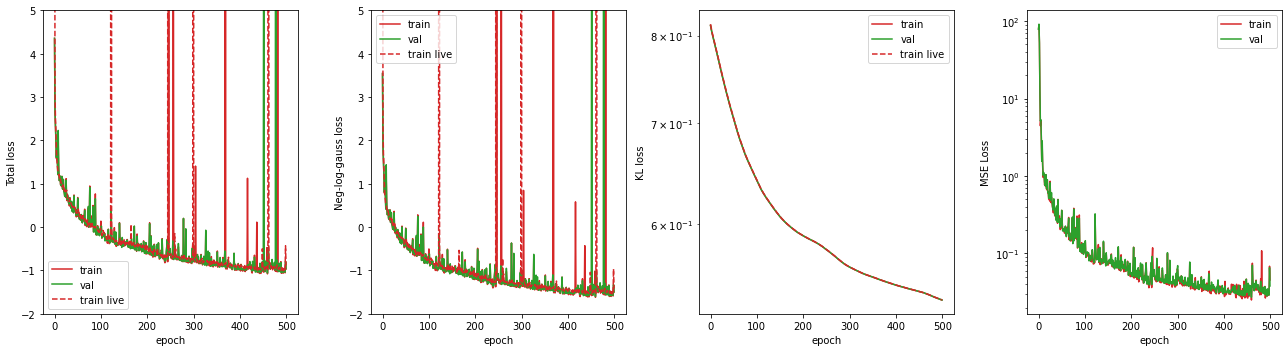

In [34]:
fig, axs = plt.subplots(1, 4, figsize=(18,5))

c1 = 'tab:red'
c2 = 'tab:green'

axs[0].plot(trn_losses, label="train", color=c1)
axs[0].plot(val_losses, label="val", color=c2)
axs[0].plot(trn_losses_live, label="train live", color=c1, ls='dashed')
axs[0].set_xlabel("epoch")
axs[0].set_ylabel("Total loss")
axs[0].set_ylim(-2, 5)
axs[0].legend()

axs[1].plot(trn_nl_losses, label="train", color=c1)
axs[1].plot(val_nl_losses, label="val", color=c2)
axs[1].plot(trn_nl_losses_live, label="train live", color=c1, ls='dashed')
axs[1].set_xlabel("epoch")
axs[1].set_ylabel("Neg-log-gauss loss")
axs[1].set_ylim(-2, 5)
axs[1].legend()

axs[2].plot(trn_kl_losses, label="train", color=c1)
axs[2].plot(val_kl_losses, label="val", color=c2)
axs[2].plot(trn_kl_losses_live, label="train live", color=c1, ls='dashed')
axs[2].set_yscale('log')
axs[2].set_xlabel("epoch")
axs[2].set_ylabel("KL loss")
axs[2].legend()


axs[3].plot(trn_mse_losses, label="train", color=c1)
axs[3].plot(val_mse_losses, label="val", color=c2)
axs[3].set_yscale('log')
axs[3].set_xlabel("epoch")
axs[3].set_ylabel("MSE Loss")
axs[3].legend()

fig.tight_layout()

We can see that both the train and validation losses are being reduced during training, the model is fitting well!

## Study the results

Now we want to get some visualisation of how well our amplitude regression has worked.

The simplest thing we can do is to pass our data through the neural network to get a predicted amplitude for each event, then histogram this and compare it to the histogram of the true amplitudes.

In [35]:
def get_prediction(model, dataloader, n_monte=30):

    # we don't need gradients here since we only use the forward pass
    with torch.no_grad():
        
        # sample from weight distributions
        amps_samples = []
        sigma2_samples = []
        for i in range(n_monte):
            print(f"Evaluating prediction: {i+1} / {n_monte}")
            # go through dataset
            amps = []
            sigma2 = []
            for X, y in dataloader:
                pred = model(X).detach().cpu().numpy()
                amps.extend(pred[:, 0]) # dimensions: [batch_size, 2]
                sigma2.extend(np.exp(pred[:, 1]))

            amps_samples.append(amps)
            sigma2_samples.append(sigma2)
           
    # dimensionaility (n_monte, batch_size)
    amps_samples = np.stack(amps_samples, axis=0)
    sigma2_samples = np.stack(sigma2_samples, axis=0)
                
    return amps_samples, sigma2_samples

In [36]:
# TURN OFF shuffeling to not mess up the weight sampling!
trn_dataloader = DataLoader(trn_dataset, batch_size=64, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
tst_dataloader = DataLoader(tst_dataset, batch_size=64, shuffle=False)

# dimensionality is (n_monte, batch_size)
pred_trn_ampls_samples, sigma2_trn_samples = get_prediction(model, trn_dataloader)
pred_val_ampls_samples, sigma2_val_samples = get_prediction(model, val_dataloader)

# compute mean prediction, standard deviation of predictions and mean sigma-output, see lecture notes
pred_trn_ampls = np.mean(pred_trn_ampls_samples, axis=0) # mean prediction
pred_trn_ampls_std = np.std(pred_trn_ampls_samples, axis=0)
pred_trn_ampls_std_stoch = np.sqrt(np.mean(sigma2_trn_samples, axis=0))
pred_trn_ampls_std_tot = np.sqrt(pred_trn_ampls_std**2 + pred_trn_ampls_std_stoch**2)

# same for validation data
pred_val_ampls = np.mean(pred_val_ampls_samples, axis=0) # mean prediction
pred_val_ampls_std = np.std(pred_val_ampls_samples, axis=0)
pred_val_ampls_std_stoch = np.sqrt(np.mean(sigma2_val_samples, axis=0))
pred_val_ampls_std_tot = np.sqrt(pred_val_ampls_std**2 + pred_val_ampls_std_stoch**2)

print("Mean std pred: ", np.mean(pred_trn_ampls_std))
print("Mean std stoch: ", np.mean(pred_trn_ampls_std_stoch))


Evaluating prediction: 1 / 30
Evaluating prediction: 2 / 30
Evaluating prediction: 3 / 30
Evaluating prediction: 4 / 30
Evaluating prediction: 5 / 30
Evaluating prediction: 6 / 30
Evaluating prediction: 7 / 30
Evaluating prediction: 8 / 30
Evaluating prediction: 9 / 30
Evaluating prediction: 10 / 30
Evaluating prediction: 11 / 30
Evaluating prediction: 12 / 30
Evaluating prediction: 13 / 30
Evaluating prediction: 14 / 30
Evaluating prediction: 15 / 30
Evaluating prediction: 16 / 30
Evaluating prediction: 17 / 30
Evaluating prediction: 18 / 30
Evaluating prediction: 19 / 30
Evaluating prediction: 20 / 30
Evaluating prediction: 21 / 30
Evaluating prediction: 22 / 30
Evaluating prediction: 23 / 30
Evaluating prediction: 24 / 30
Evaluating prediction: 25 / 30
Evaluating prediction: 26 / 30
Evaluating prediction: 27 / 30
Evaluating prediction: 28 / 30
Evaluating prediction: 29 / 30
Evaluating prediction: 30 / 30
Evaluating prediction: 1 / 30
Evaluating prediction: 2 / 30
Evaluating predicti

First for the training data:

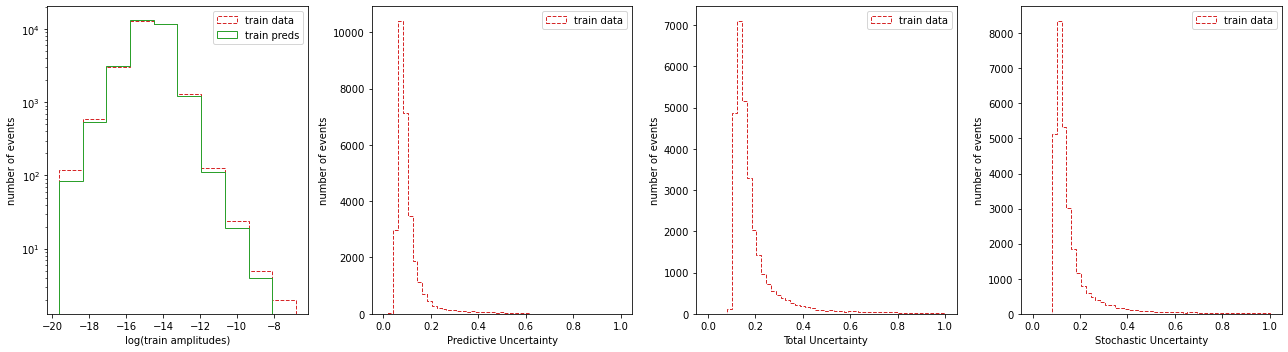

In [37]:
fig, axs = plt.subplots(1, 4, figsize=(18,5))

c1 = 'tab:red'
c2 = 'tab:green'

(n1, bins, patches1 ) = axs[0].hist(trn_ampl, histtype='stepfilled', fill=None, edgecolor=c1, label="train data", ls="--")
(n2, _, patches2 ) = axs[0].hist(pred_trn_ampls, histtype='stepfilled', fill=None, edgecolor=c2, label="train preds", bins=bins)

bins= np.linspace(0, 1., 50)
(n3, _, patches3 ) = axs[1].hist(pred_trn_ampls_std, bins=bins, histtype='stepfilled', fill=None, edgecolor=c1, label="train data", ls="--")
(n4, _, patches4 ) = axs[2].hist(pred_trn_ampls_std_tot, bins=bins, histtype='stepfilled', fill=None, edgecolor=c1, label="train data", ls="--")
(n5, _, patches5 ) = axs[3].hist(pred_trn_ampls_std_stoch, bins=bins, histtype='stepfilled', fill=None, edgecolor=c1, label="train data", ls="--")

axs[0].set_yscale('log')
axs[0].set_xlabel("log(train amplitudes)")
axs[0].set_ylabel("number of events")
axs[0].legend(loc='best')

axs[1].set_xlabel("Predictive Uncertainty")
axs[1].set_ylabel("number of events")
axs[1].legend(loc='best')

axs[2].set_xlabel("Total Uncertainty ")
axs[2].set_ylabel("number of events")
axs[2].legend(loc='best')

axs[3].set_xlabel("Stochastic Uncertainty")
axs[3].set_ylabel("number of events")
axs[3].legend(loc='best')

fig.tight_layout()

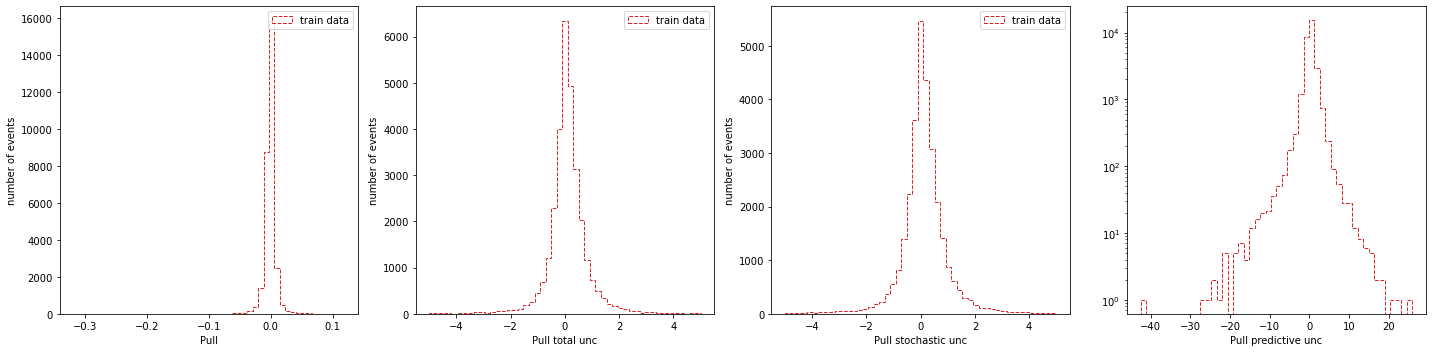

In [38]:
fig, axs = plt.subplots(1, 4, figsize=(20,5))

c1 = 'tab:red'
c2 = 'tab:green'

n_bins = 50
bins = np.linspace(-5, 5, n_bins)

pull = (trn_ampl - pred_trn_ampls) / trn_ampl
pull_normalized_tot = (trn_ampl - pred_trn_ampls) / pred_val_ampls_std_tot
pull_normalized_stoch = (trn_ampl - pred_trn_ampls) / pred_val_ampls_std_stoch
pull_normalized = (trn_ampl - pred_trn_ampls) / pred_val_ampls_std


(n1, bins1, patches1 ) = axs[0].hist( pull, histtype='stepfilled', bins=n_bins, fill=None, edgecolor=c1, label="train data", ls="--" )
(n2, bins2, patches2 ) = axs[1].hist( pull_normalized_tot, histtype='stepfilled', bins=np.linspace(-5, 5, n_bins), fill=None, edgecolor=c1, label="train data", ls="--" )
(n3, bins3, patches3 ) = axs[2].hist( pull_normalized_stoch, histtype='stepfilled', bins=np.linspace(-5, 5, n_bins), fill=None, edgecolor=c1, label="train data", ls="--" )
(n4, bins4, patches4 ) = axs[3].hist( pull_normalized, histtype='stepfilled', bins=n_bins, fill=None, edgecolor=c1, label="train data", ls="--" )

axs[0].set_xlabel("Pull")
axs[0].set_ylabel("number of events")
axs[0].legend(loc='best')

axs[1].set_xlabel("Pull total unc")
axs[1].set_ylabel("number of events")
axs[1].legend(loc='best')

axs[2].set_xlabel("Pull stochastic unc")
axs[2].set_ylabel("number of events")
axs[2].legend(loc='best')

axs[3].set_yscale('log')
axs[3].set_xlabel("Pull predictive unc")

fig.tight_layout()

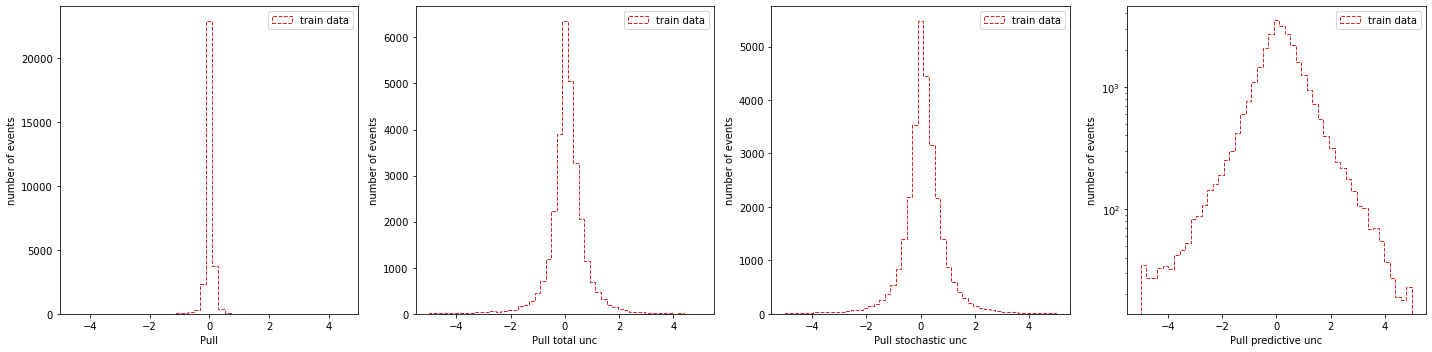

In [39]:
# same plots for exp(log (train amplitudes) ) = train amplitudes

fig, axs = plt.subplots(1, 4, figsize=(20,5))

c1 = 'tab:red'
c2 = 'tab:green'

n_bins = 50
bins =np.linspace(-5, 5, n_bins)

# revert preprocessing
trn_ampl_exp = np.exp(trn_ampl)
pred_trn_ampls_exp = np.exp(pred_trn_ampls)
pred_val_ampls_std_tot_exp = np.exp(trn_ampl) * pred_val_ampls_std_tot # error propagation
pred_val_ampls_std_stoch_exp = np.exp(trn_ampl) * pred_val_ampls_std_stoch # error propagation
pred_val_ampls_std_exp = np.exp(trn_ampl) * pred_val_ampls_std # error propagation

pull = (trn_ampl_exp - pred_trn_ampls_exp) / trn_ampl_exp
pull_normalized_tot = (trn_ampl_exp - pred_trn_ampls_exp) / pred_val_ampls_std_tot_exp
pull_normalized_stoch = (trn_ampl_exp - pred_trn_ampls_exp) / pred_val_ampls_std_stoch_exp
pull_normalized = (trn_ampl_exp - pred_trn_ampls_exp) / pred_val_ampls_std_exp
(n1, bins1, patches1 ) = axs[0].hist(pull, histtype='stepfilled', bins=bins, fill=None, edgecolor=c1, label="train data", ls="--")
(n2, bins2, patches2 ) = axs[1].hist(pull_normalized_tot, histtype='stepfilled', bins=bins, fill=None, edgecolor=c1, label="train data", ls="--")
(n3, bins3, patches3 ) = axs[2].hist(pull_normalized_stoch, histtype='stepfilled', bins=bins, fill=None, edgecolor=c1, label="train data", ls="--")
(n4, bins4, patches4 ) = axs[3].hist(pull_normalized, histtype='stepfilled', bins=bins, fill=None, edgecolor=c1, label="train data", ls="--")


axs[0].set_xlabel("Pull")
axs[0].set_ylabel("number of events")
axs[0].set_xlim([-5, 5])
axs[0].legend(loc='best')

axs[1].set_xlabel("Pull total unc")
axs[1].set_ylabel("number of events")
axs[1].legend(loc='best')

axs[2].set_xlabel("Pull stochastic unc")
axs[2].set_ylabel("number of events")
axs[2].legend(loc='best')

axs[3].set_yscale('log')
axs[3].set_xlabel("Pull predictive unc")
axs[3].set_ylabel("number of events")
axs[3].legend(loc='best')

fig.tight_layout()

The error is lowest in the regions where there is more training data, this is expected.  The more data the network has to learn from, the better it can learn to predict the correct amplitude.

And then for the validation data:

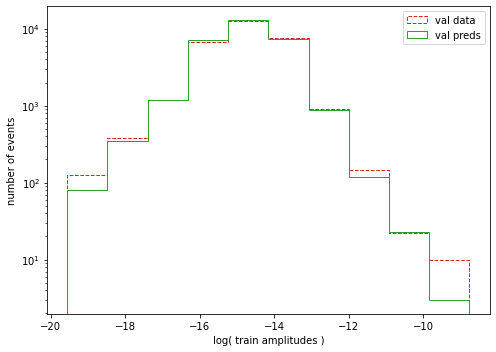

In [40]:
fig, axs = plt.subplots(1, 1, figsize=(7, 5))

c1 = 'tab:red'
c2 = 'tab:green'

(n1, bins, patches1) = axs.hist(val_ampl, histtype='stepfilled', fill=None, edgecolor=c1, label="val data", ls="--")
(n2, _, patches2) = axs.hist(pred_val_ampls, histtype='stepfilled', fill=None, edgecolor=c2, label="val preds", bins=bins)

axs.set_yscale('log')

axs.set_xlabel("log( train amplitudes )")
axs.set_ylabel("number of events")

axs.legend(loc='best')

fig.tight_layout()

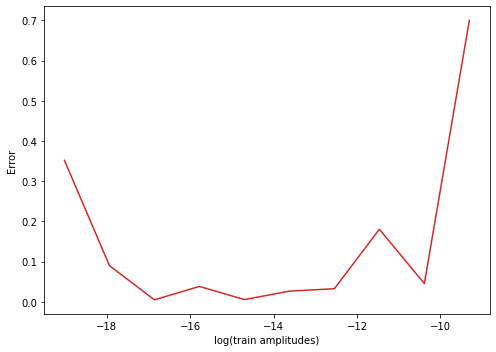

In [41]:
fig, axs = plt.subplots(1, 1, figsize=(7,5))

c1 = 'tab:red'
c2 = 'tab:green'

axs.plot((bins[1:]+bins[:-1])/2., np.abs((n1-n2)/n1), color=c1)

axs.set_xlabel("log(train amplitudes)")
axs.set_ylabel("Error")

fig.tight_layout()